In [4]:
install.packages("themis")

also installing the dependencies ‘fastmatch’, ‘ParamHelpers’, ‘BBmisc’, ‘checkmate’, ‘parallelMap’, ‘XML’, ‘hardhat’, ‘ipred’, ‘mlr’, ‘doParallel’, ‘FNN’, ‘recipes’, ‘generics’, ‘RANN’, ‘ROSE’, ‘unbalanced’


Warning message in install.packages("themis"):
“installation of package ‘parallelMap’ had non-zero exit status”
Warning message in install.packages("themis"):
“installation of package ‘mlr’ had non-zero exit status”
Warning message in install.packages("themis"):
“installation of package ‘unbalanced’ had non-zero exit status”
Warning message in install.packages("themis"):
“installation of package ‘themis’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [30]:
#attach packages
library(repr)
library(tidyverse)
library(tidymodels)
library(generics)

options(repr.matrix.max.rows = 6)
library(themis)

ERROR: Error in library(themis): there is no package called ‘themis’


In [31]:
dataset <- read_csv("Wine_quality.csv")
#renames the columns and gets rid of the spaces
colnames(dataset)<- c('fix_acid','vol_acid','citric_acid','resid_sugar','chlorides','free_sugar_dioxide','total_sulfur_dioxide','density','pH','sulphates','alcohol','quality','id')
upd <- dataset %>%
         #turns quality variable into a factor
         mutate(quality = as_factor(quality))

#moves ID column at the beginning 
updated_dataset <- upd[,c(13,1,2,3,4,5,6,7,8,9,10,11,12)]
updated_dataset


Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double(),
  Id = col_double()
)



id,fix_acid,vol_acid,citric_acid,resid_sugar,chlorides,free_sugar_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1594,6.2,0.600,0.08,2.0,0.090,32,44,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39,51,0.99512,3.52,0.76,11.2,6
1597,5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5


In [32]:
#set seed (only once)
set.seed(4321)

wine_split <- initial_split(updated_dataset, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

wine_train

id,fix_acid,vol_acid,citric_acid,resid_sugar,chlorides,free_sugar_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1594,6.2,0.600,0.08,2.0,0.090,32,44,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39,51,0.99512,3.52,0.76,11.2,6
1597,5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5


In [33]:
wine_summarize <- wine_train%>% 
                       group_by(quality)%>%
                       summarise(vol_acid_avg = median(vol_acid), alcohol_avg = median(alcohol), total_sulfur_dioxide_avg = median(total_sulfur_dioxide),sulphates_avg = median(sulphates), density_avg = median(density), count = n())


                        
#The quality distribution falls into the Gaussian normal distribution

#We see that median volatile acidity decreases as quality increases, while median alcohol content and total sulpher dioxide increase with quality
wine_summarize

`summarise()` ungrouping output (override with `.groups` argument)



quality,vol_acid_avg,alcohol_avg,total_sulfur_dioxide_avg,sulphates_avg,density_avg,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
3,0.76,9.95,12,0.630,0.99600,3
4,0.68,9.90,24,0.570,0.99664,25
5,0.59,9.60,47,0.575,0.99691,362
6,0.49,10.50,35,0.640,0.99660,345
7,0.36,11.70,28,0.750,0.99535,110
8,0.36,12.50,19,0.720,0.99516,13


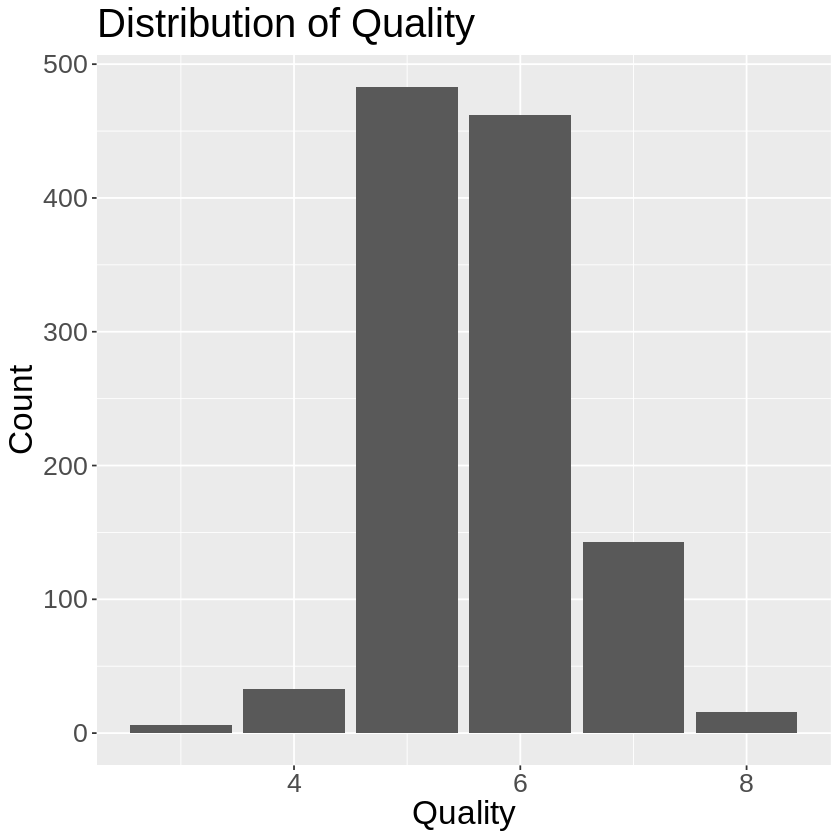

In [34]:
#This graph shows that the dataset includes many more medium quality wines than it does very good or very bad quality wines. 
#We may need to upsample to deal with this

bar_overall <- dataset%>%
                ggplot(aes(x = quality))+
                geom_bar(stat= "count")+
                labs(x = 'Quality', title = "Distribution of Quality", y = "Count")+
                theme(text = element_text(size = 20))
bar_overall

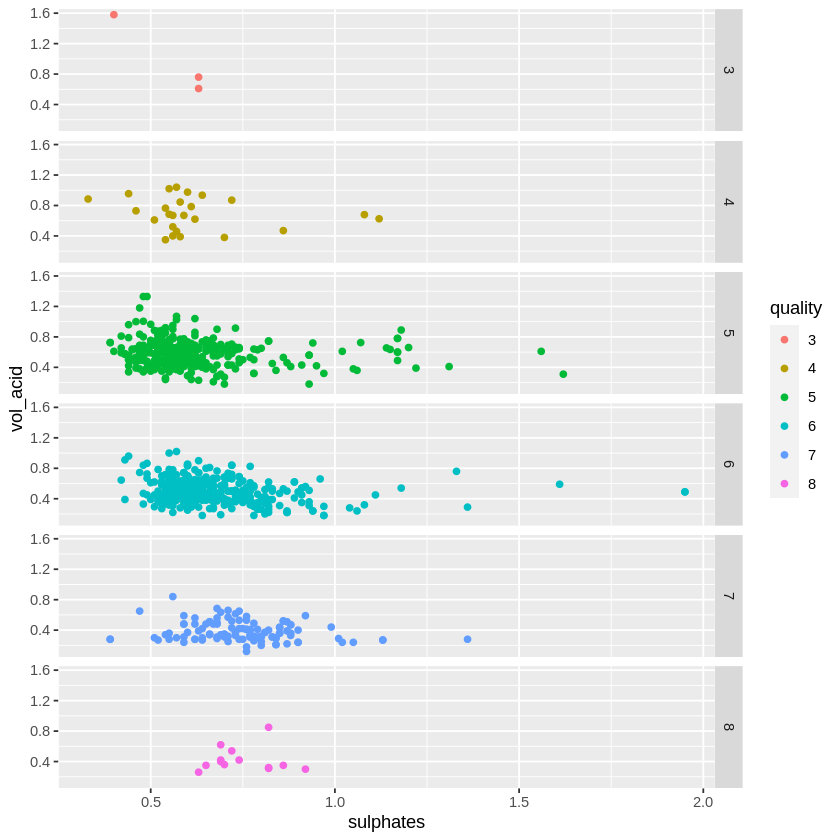

In [35]:
#Graph of volatile acid vs sulphates showing how these chemicals vary with the quality of the wine.
#Sulphates appear to increase in higher quality wine, while volatile acid appears to decrease with quality

data_visualization <- wine_train %>%
                     ggplot(aes(y = vol_acid, x = sulphates, color = quality))+
                     geom_point()+
                     facet_grid(rows = vars(quality))
data_visualization

In [36]:
#Artemis: find best K

#Create model
wine_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

In [37]:
#create recipe
wine_recipe <- recipe(quality ~ vol_acid + alcohol + total_sulfur_dioxide + sulphates + density, data = wine_train)%>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors()) #%>%
#             step_upsample(quality, over_ratio=1, ratio = NA,
#   role = NA,
#   trained = FALSE,
#   column = NULL,
#   target = NA,
#   skip = TRUE,
#   seed = sample.int(10^5, 1),
#   id = rand_id("upsample")) 


In [38]:
#5 fold cross validation
cross_val_data <- vfold_cv(wine_train, v=5, strata=quality)

#create grid specifications
sequence <- tibble(neighbors = seq(from=10, to=70, by=2))

#tune grid
determining_k <- workflow()%>%
    add_recipe(wine_recipe)%>%
    add_model(wine_model)%>%
    tune_grid(resamples=cross_val_data, grid=sequence)%>%
    collect_metrics()%>%
    filter(.metric=="accuracy")

determining_k
#step_upsample()



! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,accuracy,multiclass,0.5781725,5,0.01443737,Model01
12,accuracy,multiclass,0.5921804,5,0.01935416,Model02
14,accuracy,multiclass,0.5980893,5,0.02366784,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
66,accuracy,multiclass,0.5956218,5,0.008084927,Model29
68,accuracy,multiclass,0.5967508,5,0.005608954,Model30
70,accuracy,multiclass,0.5990695,5,0.008828867,Model31


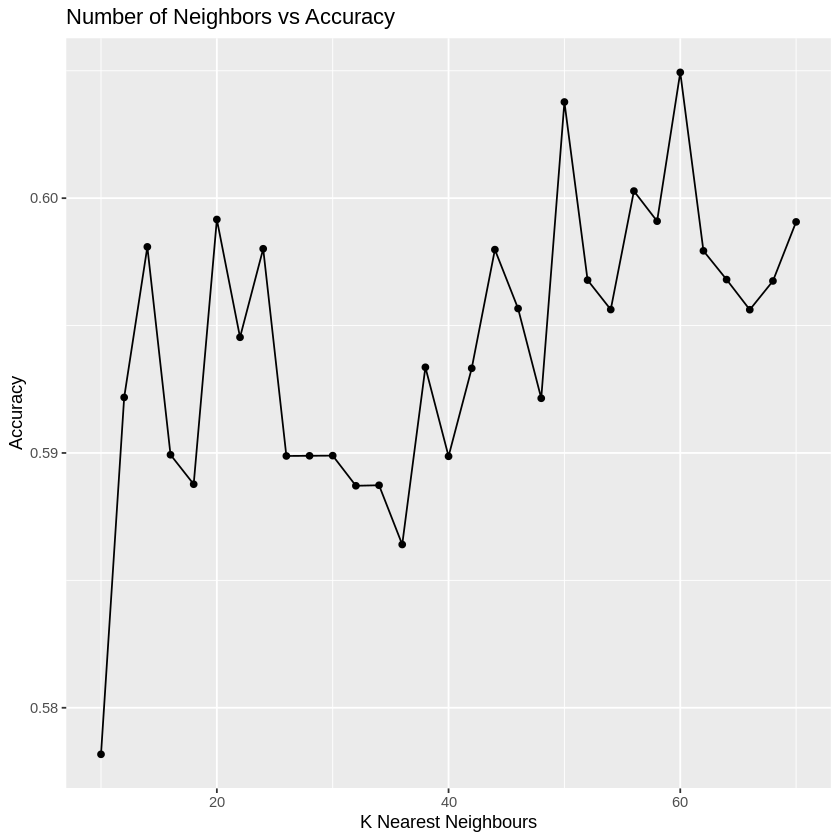

In [40]:
#graphs K vs accuracy to find best K
best_k <- ggplot(determining_k, aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
    labs(x="K Nearest Neighbours", y="Accuracy")+
    ggtitle("Number of Neighbors vs Accuracy")
best_k
#best K is 20

In [ ]:
#?step_upsample

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


ERROR: Error: Please supply at least one variable specification.See ?selections.
